# Lectura

In [ ]:
import pandas as pd
import os
import gc
import pyarrow.feather as feather

df=pd.DataFrame()
directory = '/content/drive/MyDrive/TFM/'
for filename in os.listdir(directory):
  if filename.endswith(".feather"):
      filepath = os.path.join(directory, filename)
      df_temp = pd.read_feather(filepath)
      df_temp.drop(columns=['x_pos', 'y_pos'], inplace = True)
      df_temp['target']=filename.split('_')[0]
      df = pd.concat([df,df_temp], ignore_index=True)
      del df_temp
      gc.collect()
      print(filename+' joined')


X=df.drop(columns=['target'])
y=df['target']

del df
gc.collect()

ALL B Ph+_1_1.feather joined
ALL B Ph-_1_1.feather joined
ALL T_1_1.feather joined
AML M0_1_2.feather joined
AML M1_1_1.feather joined
AML M2_1_1.feather joined
AML M3_1_1.feather joined
AML M5a_1_1.feather joined
AML M6_1_1.feather joined


0

# Preprocesado

## Preprocesado obligatorio (acotar frecuencias y vector de frecuencias equidistante de 2 cm⁻¹)

In [ ]:
def sep_2cm(X):
    import numpy as np
    import pandas as pd
    from scipy.interpolate import interp1d
    X.columns = X.columns.astype(float)
    X=X.interpolate(method='index', limit_direction='both', axis=1) #Nos deshacemos de NaNs

    # Definimos una nueva lista de frecuencias con separación de 2 cm⁻¹
    wavenumbers = X.columns

    # Definimos una nueva lista de frecuencias con separación de 2 cm⁻¹
    new_wavenumbers = np.arange(start=wavenumbers.min(), stop=wavenumbers.max(), step=2)

    # Creamos un DataFrame vacío para almacenar los datos interpolados
    X_step = pd.DataFrame(columns=new_wavenumbers)

    # Interpolamos cada columna del DataFrame X
    for index, row in X.iterrows():
        intensities = row.values
        interpolator = interp1d(wavenumbers, intensities, kind='linear', fill_value="extrapolate")
        new_intensities = interpolator(new_wavenumbers)
        X_step.loc[index] = new_intensities
    return X_step

In [ ]:
def acotar(X, truncation_min, truncation_max):
    data_copy = X.copy()
    data_copy.columns = data_copy.columns.astype(float)
    wavenumbers = data_copy.columns
    wavenumbers_filtered = wavenumbers[(wavenumbers >= truncation_min) & (wavenumbers <= truncation_max)]

    return data_copy[wavenumbers_filtered.astype(float)]

In [ ]:
X_pre = sep_2cm(acotar(X,550,3100))

In [ ]:
X_pre.to_feather('/content/drive/MyDrive/TFM/preprocesado/X_obligatorio.feather') #guaradmos en disco para usarlo depues

In [ ]:
import pandas as pd
X_pre = pd.read_feather('/content/drive/MyDrive/TFM/preprocesado/X_obligatorio.feather') #cargamos el feather guardado previamente  si es necesario

## Tratamiento del background

In [ ]:
def background(data, clustering_min=2800, clustering_max=3030):
    from sklearn.cluster import KMeans
    from scipy.ndimage import label, binary_erosion, generate_binary_structure
    import numpy as np

    # Convertir las columnas a tipo float y asegurar que los tipos son correctos
    data_copy = data.copy()
    data_copy.columns = data_copy.columns.astype(float)
    wavenumbers = data_copy.columns

     # Filtrar las frecuencias dentro del rango especificado
    wavenumbers_clustering = wavenumbers[(wavenumbers >= clustering_min) & (wavenumbers <= clustering_max)]
    data_clustering = data_copy[wavenumbers_clustering]

    # Realizar k-means con 4 clusters
    kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
    clusters = kmeans.fit_predict(data_clustering)

    # Encontrar el cluster con la media más baja
    cluster_means = data_clustering.groupby(clusters).mean().mean(axis=1)
    background_cluster = cluster_means.idxmin()

    # Calcular el espectro medio del cluster con la media más baja
    background_spectra = data_copy[clusters == background_cluster]
    background_median_spectrum = background_spectra.median()

    # Restar el espectro medio de fondo del conjunto de datos original
    data_corrected = data_copy - background_median_spectrum

    # Excluimos el background
    foreground_data = data_corrected[clusters != background_cluster]

    # Tratamiento para eliminar pequeñas regiones aisladas y aplicar erosión morfológica.
    foreground_mask = np.ones(len(foreground_data), dtype=bool)

    # Identificar y eliminar pequeñas regiones aisladas (componentes conectados con menos de 64 píxeles)
    structure = generate_binary_structure(1, 1)
    labeled_array, num_features = label(foreground_mask, structure=structure)
    sizes = np.bincount(labeled_array.ravel())
    mask_sizes = sizes >= 64
    mask_sizes[0] = 0
    foreground_mask = mask_sizes[labeled_array]

    # Aplicar erosión morfológica
    foreground_mask_eroded = binary_erosion(foreground_mask, structure=np.ones(3))

    return foreground_data[foreground_mask_eroded]

In [ ]:
X_background = background(X_pre)

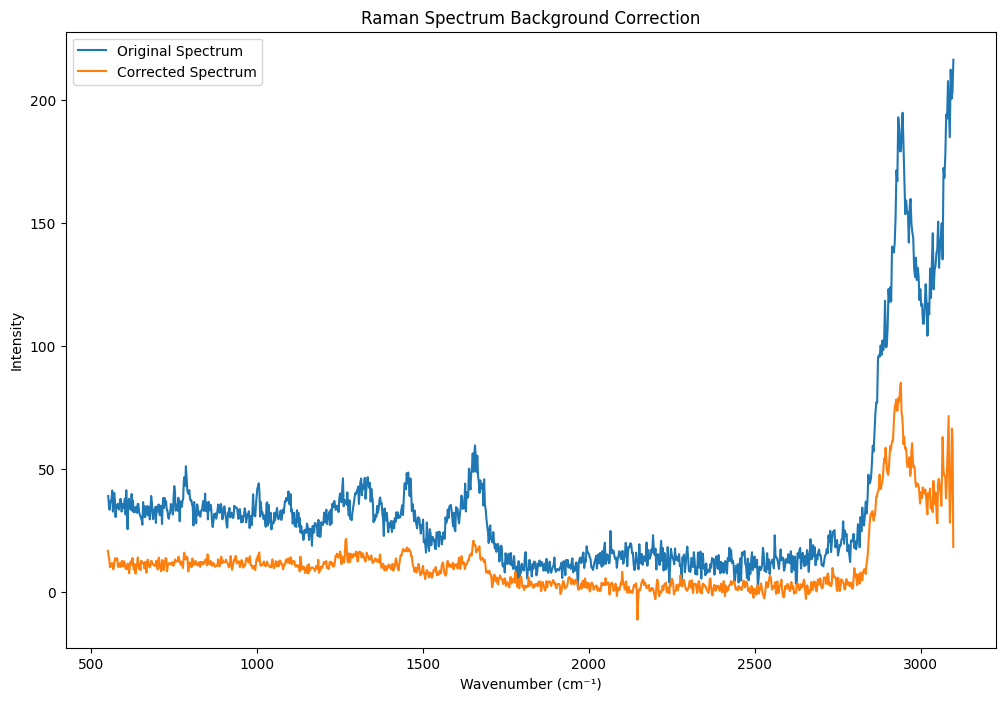

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(acotar(X,550,3100).iloc[6000], label='Original Spectrum')
plt.plot(X_background.iloc[6000], label='Corrected Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Background Correction')
plt.show()

## Whittaker-Eilers smoother

In [ ]:
def whittaker_eilers_smoother(df, lmbda=100, d=2):
    def apply_whittaker_eilers_smoother(series):
        import numpy as np
        from scipy.sparse import eye, diags
        from scipy.sparse.linalg import spsolve

        y = series.values
        m = len(y)
        E = eye(m, format='csc')
        D = E[1:] - E[:-1]
        for i in range(1, d):
            D = D[1:] - D[:-1]

        H = lmbda * D.T @ D
        z = spsolve(E + H, y)
        return pd.Series(z, index=series.index, name=series.name)

    return df.apply(apply_whittaker_eilers_smoother, axis=1)

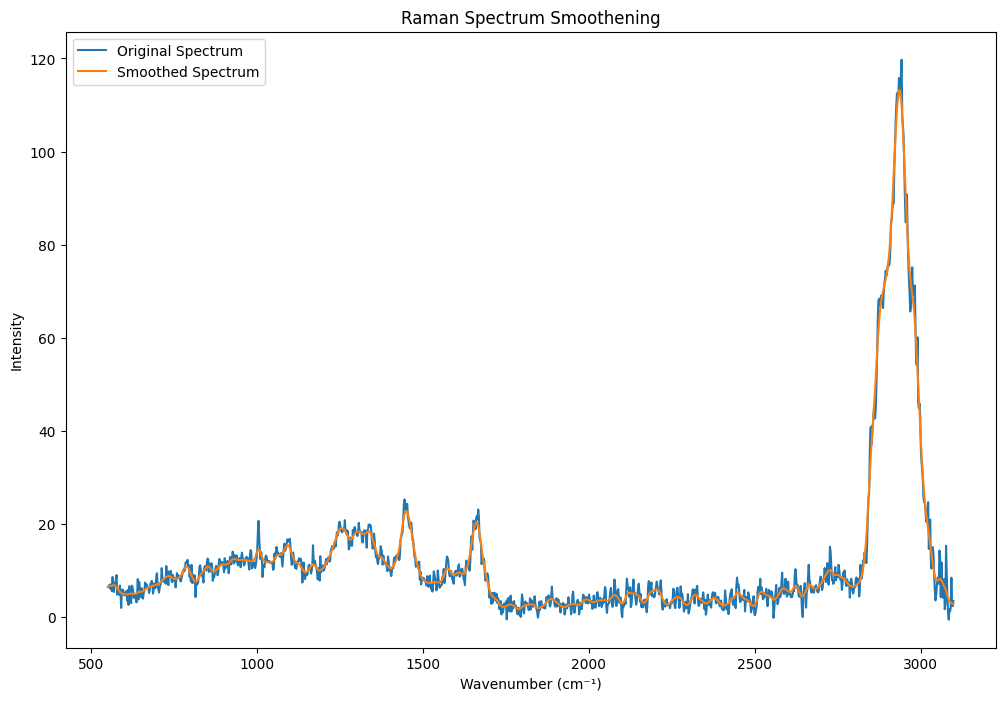

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_background.iloc[9000], label='Original Spectrum')
plt.plot(whittaker_eilers_smoother_series(X_background.iloc[9000],100,2), label='Smoothed Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Smoothening')
plt.show()

##  Baseline correction

### Rubberband method

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

def rubberband_baseline_correction(df):
    def apply_rubberband(series):
        x = np.arange(len(series))
        y = series.values

        v = ConvexHull(np.column_stack([x, y])).vertices
        v = np.roll(v, -v.argmin())
        v = v[:v.argmax() + 1]

        baseline = np.interp(x, x[v], y[v])
        corrected = y - baseline
        return pd.Series(corrected, index=series.index, name=series.name)

    return df.apply(apply_rubberband, axis=1)

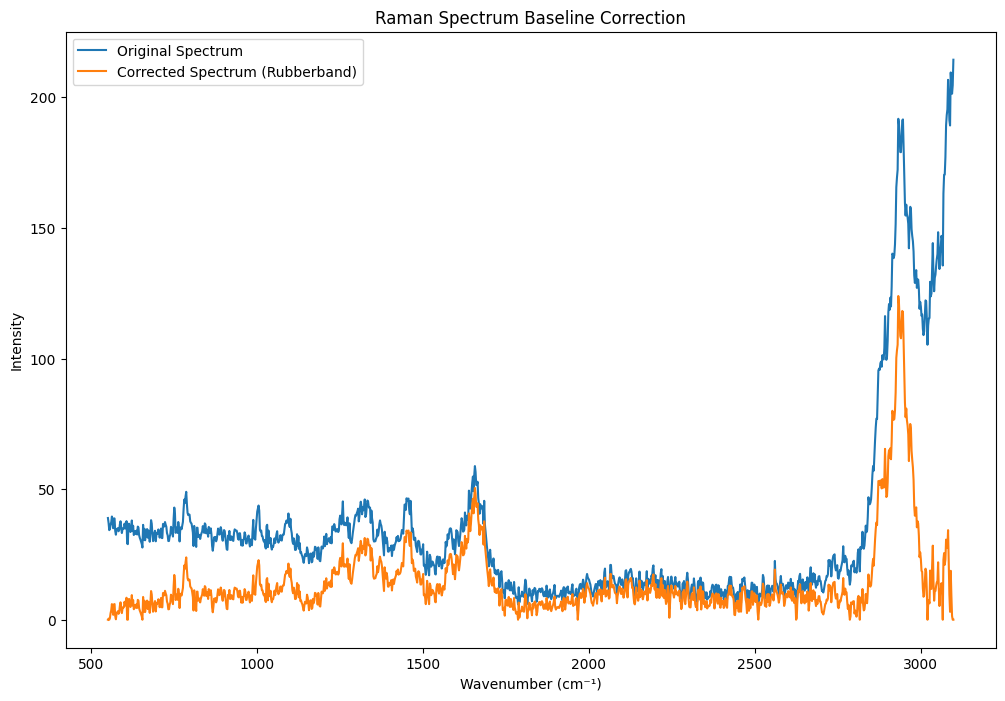

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_pre.iloc[6000], label='Original Spectrum')
plt.plot(rubberband_baseline_correction(X_pre).iloc[6000], label='Corrected Spectrum (Rubberband)')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Baseline Correction')
plt.show()

### SNIP (Statistics-sensitive Non-linear Iterative Peak-clipping)

In [ ]:
!pip install pybaselines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pybaselines import Baseline

def snip_baseline_correction(df, max_half_window=25):
    def apply_snip(series):
        y = series.values
        snip_baseline = Baseline().snip(y, max_half_window=max_half_window)[0]
        return pd.Series(y - snip_baseline, index=series.index, name=series.name)

    return df.apply(apply_snip, axis=1)

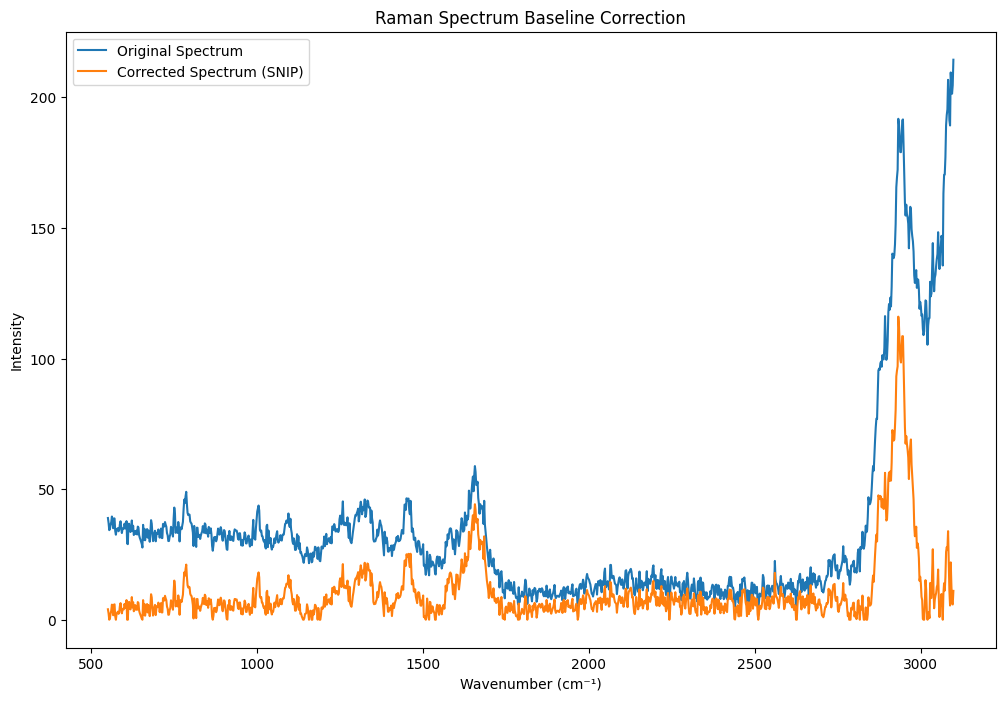

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_pre.iloc[6000], label='Original Spectrum')
plt.plot(snip_baseline_correction(X_pre).iloc[6000], label='Corrected Spectrum (SNIP)')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Baseline Correction')
plt.show()

### ASL

In [ ]:
import pandas as pd
from pybaselines import Baseline

def als_baseline_correction(df):
    def apply_als(series):
        y = series.values
        als_baseline = Baseline().asls(y)[0]
        return pd.Series(y - als_baseline, index=series.index, name=series.name)

    return df.apply(apply_als, axis=1)

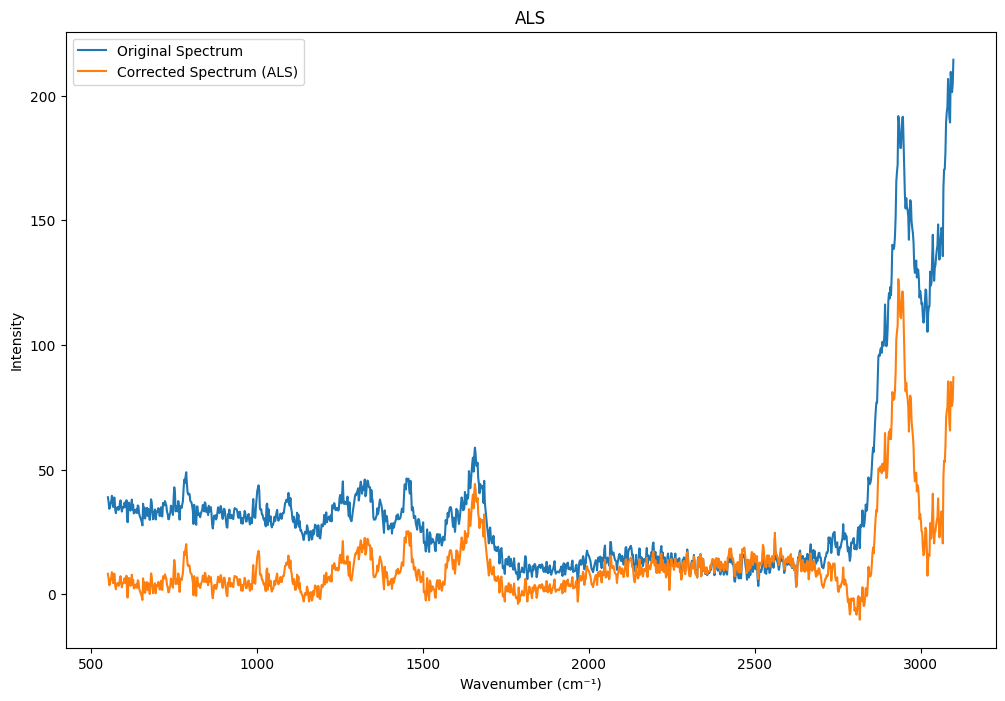

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_pre.iloc[6000], label='Original Spectrum')
plt.plot(als_baseline_correction(X_pre).iloc[6000], label='Corrected Spectrum (ALS)')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('ALS')
plt.show()

## Normalizaciones

###  unit vector normalization (norma L2)

In [ ]:
def unit_vector_normalization(X):
    import numpy as np
    def apply_unit_vector_normalization(series):
        return series / np.linalg.norm(series)

    return X.apply(apply_unit_vector_normalization, axis=1)

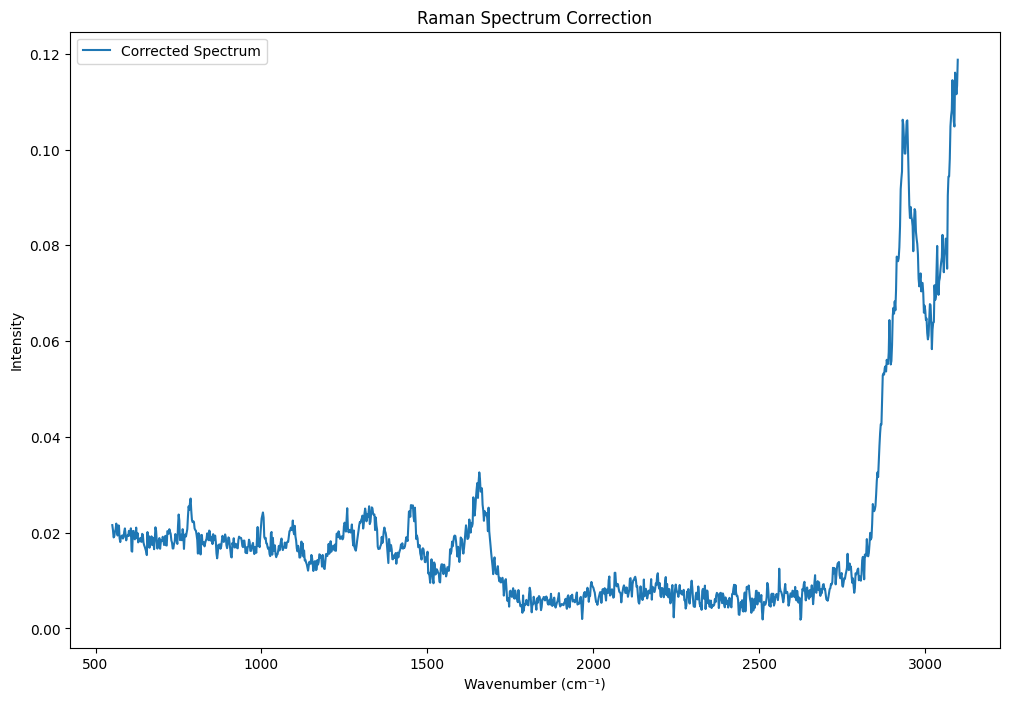

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(unit_vector_normalization(X_pre).iloc[6000], label='Corrected Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Correction')
plt.show()

### Min max

In [ ]:
def min_max(X):
  import numpy as np
  def apply_min_max(series):
    return (series - series.min()) / (series.max() - series.min())

  return X.apply(apply_min_max, axis=1)


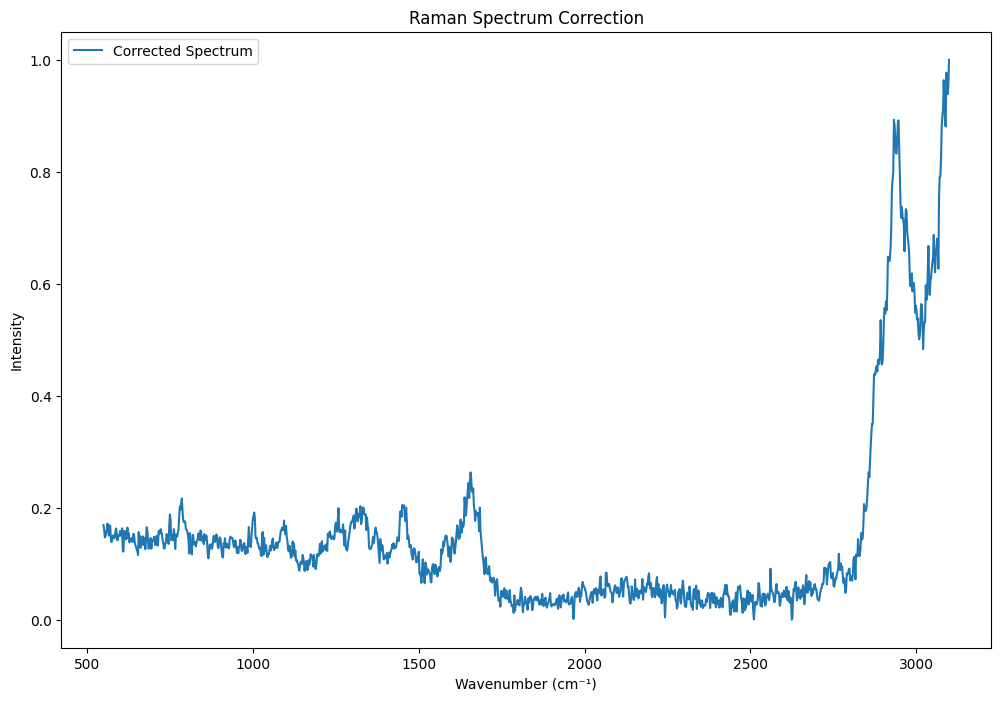

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(min_max(X_pre).iloc[6000],
         label='Corrected Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Correction')
plt.show()

In [ ]:
min_max(X_pre).iloc[6000].describe()

,6000
count,1275.000000
mean,0.147725
std,0.175260
min,0.000000
25%,0.047910
50%,0.111651
75%,0.149522
max,1.000000


### Standarización

In [ ]:
def standard(X):
    import numpy as np
    def apply_standard(series):
        return (series - series.mean()) / series.std()

    return X.apply(apply_standard, axis=1)

In [ ]:
standard(X_pre).iloc[6000].describe()

,6000
count,1.275000e+03
mean,4.458307e-17
std,1.000000e+00
min,-8.428926e-01
25%,-5.695251e-01
50%,-2.058346e-01
75%,1.025207e-02
max,4.862930e+00


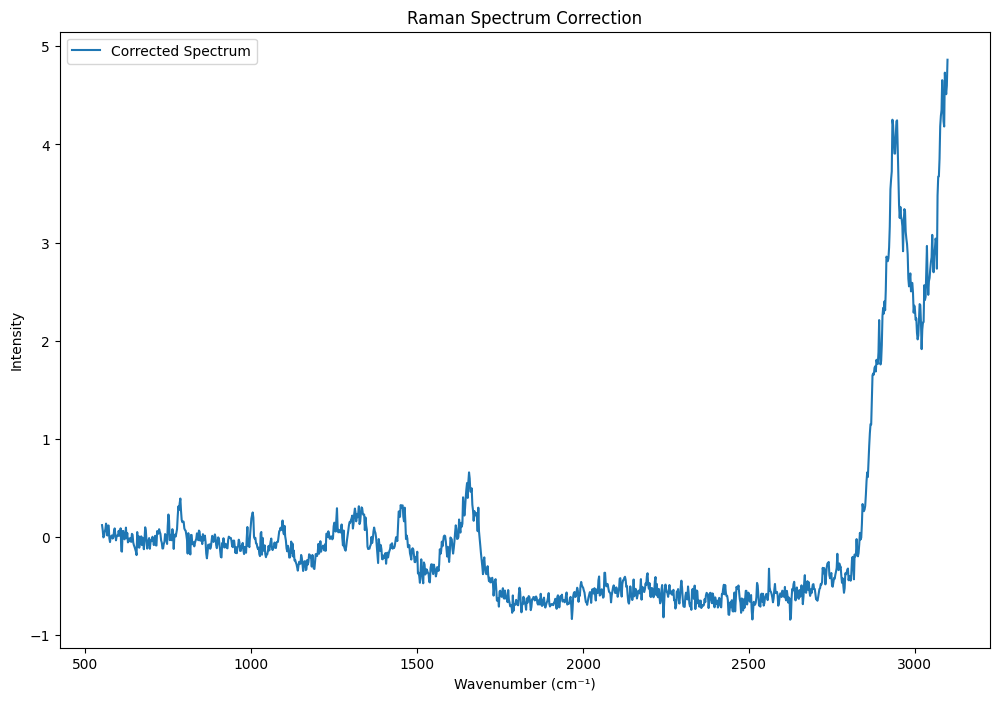

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(standard(X_pre).iloc[6000], label='Corrected Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Correction')
plt.show()

# Comparativa de algoritmos

## Comparación de los posibles preprocesados

In [ ]:
# Defino funciones para combinar los pasos de preprocesado y aplicarlos a un DataFrame

def generate_preprocessing_combinations(preprocessing_steps, exclude_groups):
    import itertools
    combinations = []
    for L in range(1, len(preprocessing_steps)+1):
        for subset in itertools.combinations(preprocessing_steps, L):
            if not any(all(step in subset for step in group) for group in exclude_groups):
                combinations.append(subset)
    return combinations

def apply_preprocessing_combinations(data, combinations):
  try:
    results = {}
    for combo in combinations:
        data_copy = data.copy()
        for step in combo:
            data_copy = step(data_copy)
        results[combo] = data_copy
    return results

  except Exception as e:
    print(f"An error occurred in {combo}, with error: {e}")
    return None

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
# Se definen las funciones que usare en el preprocesado
def acotado_600_1800(X): return acotar(X,600,1800)
def acotado_2800_3030(X): return acotar(X,2800,3030)

# Se declaran los pasos de procesado que se quieren combinar
preprocessing_steps = [
    background,
    whittaker_eilers_smoother,
    rubberband_baseline_correction,
    acotado_600_1800,
    acotado_2800_3030,
    unit_vector_normalization,
    min_max,
    standard,
]

# Se aplican restriccionen para selccionar solo una normalizacion
exclude_groups = [
    ('unit_vector_normalization', 'standard'),
    ('unit_vector_normalization', 'minmax'),
    ('standard', 'minmax'),
    ('acotado_600_1800','acotado_2800_3030'),
    ('acotado_600_1800','background')


]

combinations = generate_preprocessing_combinations(preprocessing_steps,exclude_groups)

results = apply_preprocessing_combinations(X_pre, combinations)

KeyboardInterrupt: 

------------------------------------

In [ ]:
from sklearn.externals import joblib

joblib.dump(results, '/content/drive/MyDrive/TFM/preprocesado/X_combinaciones.feather')

In [ ]:
from sklearn.decomposition import PCA, FastICA, NMF, LatentDirichletAllocation, SparsePCA, IncrementalPCA, FactorAnalysis, TruncatedSVD
from sklearn.cross_decomposition import PLSRegression,PLSCanonical, PLSSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

# probar diferentes normalizaciones y preprocesados del notebook inicial


# MinMax Scaler for NMF (non-negative matrix factorization)
scaler_minmax = MinMaxScaler()
scaled_data_minmax = scaler_minmax.fit_transform(X_samp)

# Encode the target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode y to numerical labels

# Function to perform classification and print scores
def perform_classification(transformed_data, labels, technique_name):
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return [accuracy, f1]

scores_PCA = []
scores_ICA = []
scores_PLS_reg = []
scores_PLS_SVD=[]
scores_NMF = []
scores_PCA_inc = []
scores_PCA_sp = []
scores_fact = []
scores_LSA = []

#partition for supervised models
X_train, X_test, y_train, y_test = train_test_split(scaled_data_minmax, y_encoded, test_size=0.3, random_state=42)

for n in range(1, 9):

  fact= FactorAnalysis(n_components=n)
  fact_result = fact.fit_transform(scaled_data_minmax)
  scores_fact.append(perform_classification(fact_result, y_encoded, "fact")) # Use encoded y

  lsa = TruncatedSVD(n_components=n)
  lsa_result = lsa.fit_transform(scaled_data_minmax)
  scores_LSA.append(perform_classification(lsa_result, y_encoded, "lsa")) # Use encoded y
  # 1. Principal Component Analysis (PCA)
  pca = PCA(n_components=n)
  pca_result = pca.fit_transform(scaled_data_minmax)
  scores_PCA.append(perform_classification(pca_result, y_encoded, "PCA")) # Use encoded y

  # 1. Principal Component Analysis (PCA)
  pca_inc = IncrementalPCA(n_components=n)
  pca_inc_result = pca_inc.fit_transform(scaled_data_minmax)
  scores_PCA_inc.append(perform_classification(pca_inc_result, y_encoded, "PCA inc"))

  # 1. Principal Component Analysis (PCA)
  pca_sp = SparsePCA(n_components=n)
  pca_sp_result = pca_sp.fit_transform(scaled_data_minmax)
  scores_PCA_sp.append(perform_classification(pca_sp_result, y_encoded, "sparsePCA"))

  # 2. Independent Component Analysis (ICA)
  ica = FastICA(n_components=n)  # Reduce to 2 components
  ica_result = ica.fit_transform(scaled_data_minmax)
  scores_ICA.append(perform_classification(ica_result, y_encoded, "ICA")) # Use encoded y

  # 4. Partial Least Squares (PLS)
  pls_reg = PLSRegression(n_components=n)  # Reduce to 2 components
  pls_reg.fit(X_train,y_train)
  pls_reg_result=pls_reg.transform(X_test)
  scores_PLS_reg.append(perform_classification(pls_reg_result,y_test, "PLS")) # Use encoded y

  # 5. Non-Negative Matrix Factorization (NMF)
  nmf = NMF(n_components=n)  # Reduce to 2 components
  nmf_result = nmf.fit_transform(scaled_data_minmax)
  scores_NMF.append(perform_classification(nmf_result, y_encoded, "NMF")) # Use encoded y
  print(n)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocess

2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

6


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

7


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

8


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


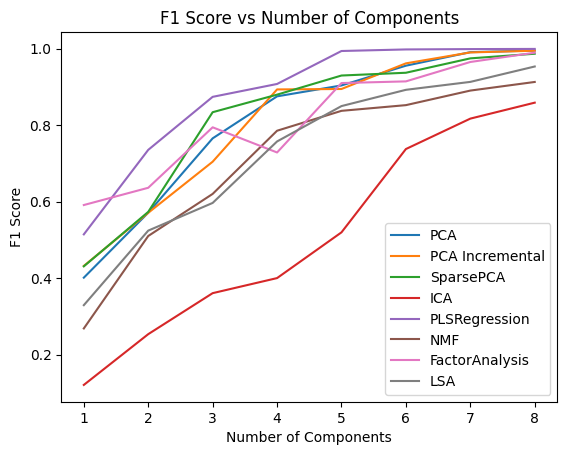

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1,9),pd.DataFrame(scores_PCA)[1],label='PCA')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_inc)[1],label='PCA Incremental')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_sp)[1],label='SparsePCA')
plt.plot(range(1,9),pd.DataFrame(scores_ICA)[1],label='ICA')
plt.plot(range(1,9),pd.DataFrame(scores_PLS_reg)[1],label='PLSRegression')
plt.plot(range(1,9),pd.DataFrame(scores_NMF)[1],label='NMF')
plt.plot(range(1,9),pd.DataFrame(scores_fact)[1],label='FactorAnalysis')
plt.plot(range(1,9),pd.DataFrame(scores_LSA)[1],label='LSA')
plt.title('F1 Score vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

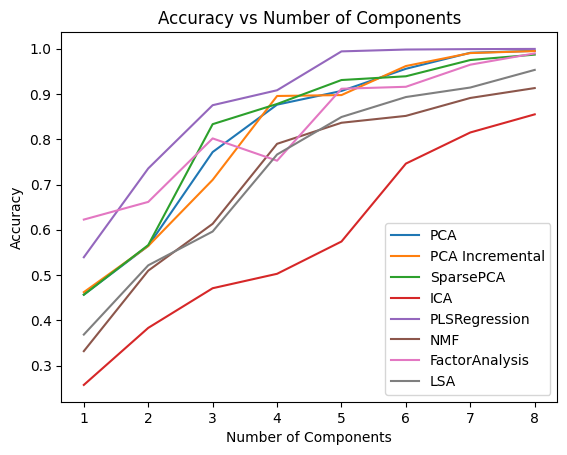

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,9),pd.DataFrame(scores_PCA)[0],label='PCA')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_inc)[0],label='PCA Incremental')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_sp)[0],label='SparsePCA')
plt.plot(range(1,9),pd.DataFrame(scores_ICA)[0],label='ICA')
plt.plot(range(1,9),pd.DataFrame(scores_PLS_reg)[0],label='PLSRegression')
plt.plot(range(1,9),pd.DataFrame(scores_NMF)[0],label='NMF')
plt.plot(range(1,9),pd.DataFrame(scores_fact)[0],label='FactorAnalysis')
plt.plot(range(1,9),pd.DataFrame(scores_LSA)[0],label='LSA')
plt.title('Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()


Parece que el odren es:
  1. **PLS**: Es de esperar que sea el mejor pues es una reduccion de dimensionalidad supervisada y el resto son no supervisadas.
  2. **PCA** en sus 3 variantes son similares
  3. **FactorAnalysis**: Similar a PCA, pero en n=4 rinde ligeramnte peor.
  4. **NMF** y **LSA** rinde similar.
  5. **ICA** es el peor de todos.